In [8]:
from cvxpy_portfolio_optimizer.objective_function import TrackingErrorObjectiveFunction, WorstRealizationObjectiveFunction
from cvxpy_portfolio_optimizer.constraint_function import SumToOneConstraint, NoShortSellConstraint, TrackingErrorConstraint
from cvxpy_portfolio_optimizer.portfolio_optimization_problem import PortfolioOptimizationProblem
import cvxpy as cp
import yfinance as yf

In [9]:
tickers = ["TSLA", "MSFT", "IBM", "GOOG", "AAPL", "AMZN", "ADBE", "EXC", "XOM", "META"]
rets = (
    yf.download(tickers, period="1y")["Adj Close"].loc[:, tickers].pct_change().iloc[1:, :].ffill()
)
rets

[*********************100%%**********************]  10 of 10 completed


Ticker,TSLA,MSFT,IBM,GOOG,AAPL,AMZN,ADBE,EXC,XOM,META
Date,,,,,,,,,,
2023-05-16,0.001022,0.007368,0.000811,0.026761,0.000000,0.019784,-0.001620,-0.034102,-0.024270,-0.000167
2023-05-17,0.044079,0.009451,0.018225,0.011575,0.003603,0.018519,0.033381,-0.002794,0.022435,0.015367
2023-05-18,0.017428,0.014395,0.003500,0.016793,0.013666,0.022944,0.010655,0.003311,0.009063,0.017980
2023-05-19,0.018373,-0.000565,0.008799,-0.002186,0.000628,-0.016081,0.030020,0.012186,0.004633,-0.004902
2023-05-22,0.048462,0.008921,0.001886,0.021258,-0.005481,-0.010667,0.002155,0.006270,-0.012140,0.010910
...,...,...,...,...,...,...,...,...,...,...
2024-05-09,-0.015739,0.004336,-0.021365,0.002454,0.010014,0.007979,-0.011166,0.013485,0.019716,0.005967
2024-05-10,-0.020352,0.005869,0.005293,-0.007518,-0.006890,-0.010660,-0.000746,-0.007378,-0.004053,0.001641
2024-05-13,0.020300,-0.002459,0.002453,0.003582,0.017645,-0.004854,0.001700,0.012211,-0.000424,-0.017199


In the following portfolio optimization problem we will:
- Minimize Tracking Error on a universe of 10 assets with respect to a benchmark, (bench_rets) in this case the SP500 etf

In [10]:
bench_rets = yf.download(["SPY"], period="1y")["Adj Close"].pct_change().iloc[1:].ffill()
bench_rets

[*********************100%%**********************]  1 of 1 completed


Date
2023-05-16   -0.006683
2023-05-17    0.012139
2023-05-18    0.009633
2023-05-19   -0.001455
2023-05-22    0.000406
                ...   
2024-05-09    0.005762
2024-05-10    0.001288
2024-05-13    0.000134
2024-05-14    0.004588
2024-05-15    0.010128
Name: Adj Close, Length: 252, dtype: float64

In [11]:
pop = PortfolioOptimizationProblem(
    returns=rets,
    objective_functions=[
        TrackingErrorObjectiveFunction(benchmark_returns=bench_rets),
    ],
    constraint_functions=[
        SumToOneConstraint(),
        NoShortSellConstraint(),
    ],
)
ptf = pop.solve(solver=cp.CLARABEL)

In [12]:
ptf.weights

TSLA    0.044624
MSFT    0.178096
IBM     0.141667
GOOG    0.068322
AAPL    0.152596
AMZN    0.081695
ADBE    0.010299
EXC     0.127274
XOM     0.163707
META    0.031720
dtype: float64

<Axes: xlabel='Date'>

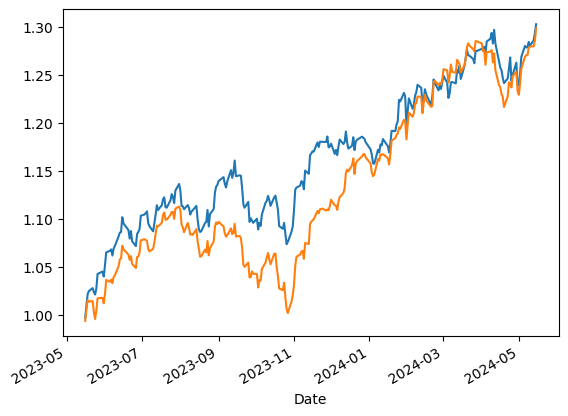

In [13]:
ptf_rets = rets.dot(ptf.weights)
(1 + ptf_rets).cumprod().plot()
(1 + bench_rets).cumprod().plot()

In [14]:
# Tracking error
(ptf_rets - bench_rets).std()

0.0034810379901279516

Tracking error can also be a constraint, and we can minimize another objective function

In [21]:
pop = PortfolioOptimizationProblem(
    returns=rets,
    objective_functions=[
        WorstRealizationObjectiveFunction()
    ],
    constraint_functions=[
        SumToOneConstraint(),
        NoShortSellConstraint(),
        TrackingErrorConstraint(benchmark_returns=bench_rets, upper_bound=0.005),
    ],
)
ptf = pop.solve(solver=cp.CLARABEL)

In [22]:
# Tracking error
ptf_rets = rets.dot(ptf.weights)
(ptf_rets - bench_rets).std()

0.004990923342561178

<Axes: >

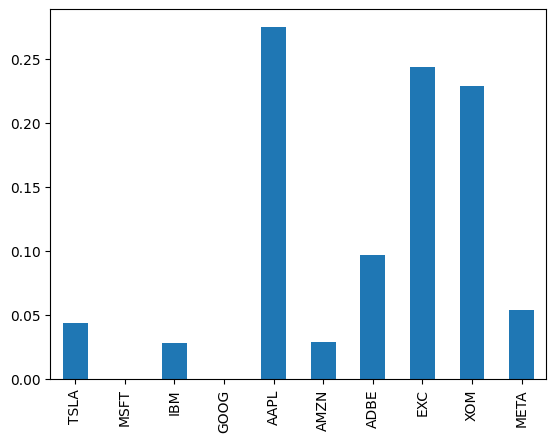

In [26]:
ptf.weights.plot.bar()